# Predicting Survivors of Titanic

The goal of this notebook is to predict the survival outcome of each individual in the test dataset from analyzing the train dataset. This dataset is from this well-known [kaggle competition](https://www.kaggle.com/c/titanic). Included are exploratory analysis, feature engineering, and model building and testing. This model resulted in an accuracy of 0.789 on the test dataset, reaching the top 29%.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train = pd.read_csv('.../train.csv')
test = pd.read_csv('.../test.csv')
train['Count'] = 1
test['Count'] = 1
sns.set_style('darkgrid')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Count          891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


Null values for Age, Cabin, and Embarked

## Exploratory Analysis and Feature Engineering

From name, we will extract the title. SibSp is the number of siblings and spouses the passenger has onboard. Parch is the number of parents or children onboard. Fare appears to be the amount a family paid for the trip for all members.

### Class

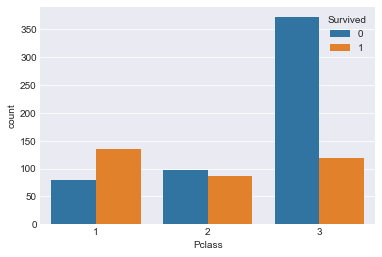

In [3]:
sns.countplot(x='Pclass', hue='Survived', data=train)

Chances of surviving the disaster from the third class are slim. First class passengers are the only ones with a >50% chance of survival.

In [4]:
trainPclass = pd.DataFrame(train.groupby('Pclass').mean()['Survived'])
trainPclass['Pclass'] = trainPclass.index
trainPclass

,Survived,Pclass
Pclass,,
1,0.629630,1
2,0.472826,2
3,0.242363,3


### Title

We can extract the title from the Name column.

In [5]:
train['Titles'] = train['Name'].apply(lambda x: x.split(', ')[1].split('. ')[0])
test['Titles'] = test['Name'].apply(lambda x: x.split(', ')[1].split('. ')[0])
train['Titles'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
the Countess      1
Capt              1
Sir               1
Don               1
Jonkheer          1
Ms                1
Mme               1
Lady              1
Name: Titles, dtype: int64

Many of these titles are too scarce to leave on their own, so we will combine them with the appropriate title among Mr, Miss, Mrs, and Master. We will leave Dr the way it is.

In [6]:
trainTitles = pd.DataFrame(train.groupby('Titles').mean()['Survived'])

In [7]:
def changeTitle(x):
    if x in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif x in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif x in ['Mlle', 'Ms']:
        return 'Miss'
    else:
        return x

In [8]:
train['New Title'] = train['Titles'].apply(lambda x: changeTitle(x))
test['New Title'] = test['Titles'].apply(lambda x: changeTitle(x))

In [9]:
trainNewTitles = pd.DataFrame(train.groupby('New Title').mean()['Survived'])
trainNewTitles['New Title'] = trainNewTitles.index
trainNewTitles

,Survived,New Title
New Title,,
Dr,0.428571,Dr
Master,0.575000,Master
Miss,0.702703,Miss
Mr,0.158192,Mr
Mrs,0.796875,Mrs


We will add a column that will represent a persons chance of survival based on title.

In [10]:
title_dict = dict(zip(trainNewTitles['New Title'], trainNewTitles['Survived']))
train['TitleProb'] = train['New Title'].replace(title_dict)
test['TitleProb'] = test['New Title'].replace(title_dict)

### Age

We need to insert values for missing ages. We will do that by replacing null with the average age of people with the same title.

In [11]:
train.loc[train['Age'].isnull()]['New Title'].value_counts()

Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: New Title, dtype: int64

In [12]:
trainFillNullAge = pd.DataFrame(train.groupby('New Title')['Age'].mean())
trainFillNullAge['New Title'] = trainFillNullAge.index
trainFillNullAge

,Age,New Title
New Title,,
Dr,42.000000,Dr
Master,4.574167,Master
Miss,21.845638,Miss
Mr,32.891990,Mr
Mrs,35.873874,Mrs


In [13]:
null_age_dict = dict(zip(trainFillNullAge['New Title'], trainFillNullAge['Age']))
train.loc[train['Age'].isnull(), 'Age'] = train['New Title'].replace(null_age_dict)
test.loc[test['Age'].isnull(), 'Age'] = test['New Title'].replace(null_age_dict)

In [14]:
train['Age'].describe(percentiles=[.05, .10, .25, .5, .75, .90, .95])

count    891.000000
mean      29.827062
std       13.290197
min        0.420000
5%         5.000000
10%       16.000000
25%       21.845638
50%       30.000000
75%       35.873874
90%       47.000000
95%       54.000000
max       80.000000
Name: Age, dtype: float64

90% of our sample are between the ages of 5 and 54, and 80% are between 16 and 47

I want to check out a scatter plot between ranges of ages and survival chance. We will need to use bins because there aren't enough data points for some ages to have their own point. In order to do this we need to see several of the highest ages to determine binning at that point.

In [15]:
train.sort_values('Age')[['Age', 'Survived']].tail(15)

,Age,Survived
483,63.0,1
275,63.0,1
438,64.0,0
545,64.0,0
280,65.0,0
54,65.0,0
456,65.0,0
33,66.0,0
672,70.0,0
745,70.0,0


Between 66 and 70 looks to be a good place to split the last bin.

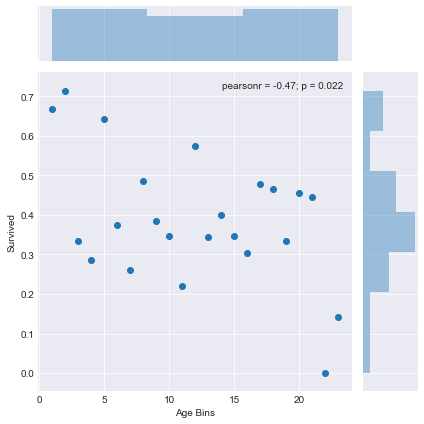

In [16]:
bins = [x for x in range(0, 69, 3)] + [80]
train['Age Bins'] = pd.cut(train['Age'], bins=bins, labels=[x for x in range(1, 24)])
test['Age Bins'] = pd.cut(train['Age'], bins=bins, labels=[x for x in range(1, 24)])
trainBins = pd.DataFrame(train.groupby('Age Bins')['Survived'].mean())
trainBins['Age Bins'] = trainBins.index
sns.jointplot(x='Age Bins', y='Survived', data=trainBins)

Despite using binning, there is a large amount of deviation anyway. The graph suggests that there are more important features involved that makes surviving difficult to determine based solely on age. For example we already know that class is important and we're about to find out that sex is important.

### Sex

The following visual shows the age where all males and females survival probabilities are starting to merge. Because of this, we will change 'Sex' from a binary category into men over 15, women over 15, and children ages 15 and under. And then change these values into floats based on probability of survival. First, we will take a look at survival based on sex.

Text(0.5,1,'Survival by Sex')

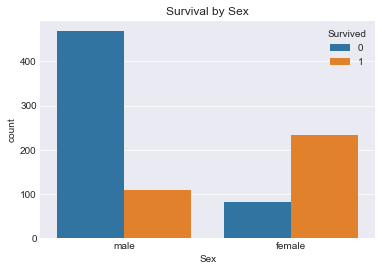

In [17]:
sns.countplot('Sex', hue='Survived', data=train)
plt.title('Survival by Sex')

The age where boys start to survive more often than not is under 16.

Text(0.5,1,'Survival of children under 16')

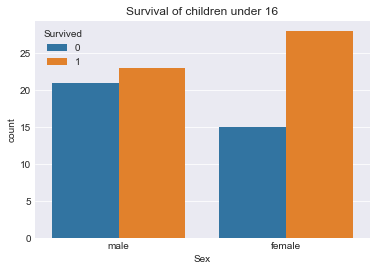

In [18]:
sns.countplot('Sex', hue='Survived', data=train[train['Age'] < 16])
plt.title('Survival of children under 16')

In [19]:
train.loc[train['Age'] < 16, 'Sex'] = 'Child'
test.loc[train['Age'] < 16, 'Sex'] = 'Child'
trainSex = pd.DataFrame(train.groupby('Sex')['Survived'].mean())
trainSex['Sex'] = trainSex.index
trainSex

,Survived,Sex
Sex,,
Child,0.586207,Child
female,0.756458,female
male,0.161351,male


We will use these new values to replace the 'Sex' column in our model.

In [20]:
sex_dict = dict(zip(trainSex['Sex'], trainSex['Survived']))
train['Sex Prob'] = train['Sex'].replace(sex_dict)
test['Sex Prob'] = test['Sex'].replace(sex_dict)

### Family

Now we will delve into the relatives each person has on board. They are divided into siblings/spouse and parents/children. Based on age, we can figure out who isn't old enough to have a spouse or children. Here we will combine these two columns into one column representing number of family members on board.

In [21]:
train['Family'] = train['SibSp'] + train['Parch']
test['Family'] = test['SibSp'] + test['Parch']

In [22]:
train[train['Age'] < 18].groupby('Family')['Survived'].mean()

Family
0     0.434783
1     0.833333
2     0.800000
3     0.916667
4     0.000000
5     0.000000
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

In [23]:
train[train['Age'] < 18]['Family'].value_counts()

2     30
0     23
1     18
5     13
3     12
6      9
4      6
7      5
10     1
Name: Family, dtype: int64

Children traveling with 1 to 3 relatives have a high chance of surviving. Chances of surving while travelling with 4 or more relatives dips dramatically and the sample sizes are small. Chances of survival with no relatives on board are predictably small.

In [24]:
train[train['Age'] >= 18].groupby('Family')['Survived'].mean()

Family
0     0.297665
1     0.517483
2     0.486111
3     0.588235
4     0.333333
5     0.333333
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

In [25]:
train[train['Age'] >= 18]['Family'].value_counts()

0     514
1     143
2      72
3      17
5       9
4       9
10      6
6       3
7       1
Name: Family, dtype: int64

Even for adults, having 1 to 3 relatives on board results in a higher chance of survival. Samples sizes of 4 or more relatives are small. Again, chances of surviving while traveling alone are slim.

Due to these statistics I will create a column that will be used in our model, using percent chance of survival as the value for all passengers travelling with 0-3 relatives. For everyone else, I will use the chance of survival for all remaining passengers as their value.

In [26]:
minor_small_fam = pd.DataFrame(train[(train['Age'] < 18) & (train['Family'] <= 3)].groupby('Family')['Survived'].mean())
minor_small_fam['Family'] = minor_small_fam.index
minor_small_fam_dict = dict(zip(minor_small_fam['Family'], minor_small_fam['Survived']))

adult_small_fam = pd.DataFrame(train[(train['Age'] >= 18) & (train['Family'] <= 3)].groupby('Family')['Survived'].mean())
adult_small_fam['Family'] = adult_small_fam.index
adult_small_fam_dict = dict(zip(adult_small_fam['Family'], adult_small_fam['Survived']))

leftover_average = train[train['Family'] > 3]['Survived'].mean()

train['Family Prob'] = leftover_average
train.loc[(train['Age'] < 18) & (train['Family'] <= 3), 'Family Prob'] = train.loc[(train['Age'] < 18) & (train['Family'] <= 3), 'Family'].replace(minor_small_fam_dict)
train.loc[(train['Age'] >= 18) & (train['Family'] <= 3), 'Family Prob'] = train.loc[(train['Age'] >= 18) & (train['Family'] <= 3), 'Family'].replace(adult_small_fam_dict)
test['Family Prob'] = leftover_average
test.loc[(test['Age'] < 18) & (test['Family'] <= 3), 'Family Prob'] = test.loc[(test['Age'] < 18) & (test['Family'] <= 3), 'Family'].replace(minor_small_fam_dict)
test.loc[(test['Age'] >= 18) & (test['Family'] <= 3), 'Family Prob'] = test.loc[(test['Age'] >= 18) & (test['Family'] <= 3), 'Family'].replace(adult_small_fam_dict)

### Fare

Text(0.5,1,'Passenger Fare by Class')

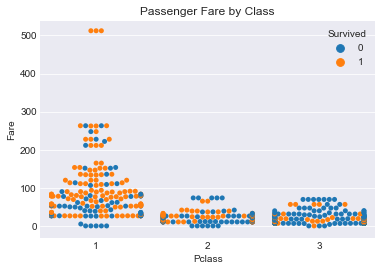

In [27]:
sns.swarmplot(x='Pclass', y='Fare', hue='Survived', data=train)
plt.title('Passenger Fare by Class')

There is a lot of overlap between all three classes in fare. This was not expected because it suggests that people from different classes paid the same for different qualities of service.

If you look closely at the first class, there appears to be a larger proportion of deaths when fare is small.

We will create a new feature called Fare Per which is the Fare divided by total family plus self on board. This is what fare appears to be and hopefully it explains why fare is similar across classes in many cases.

Text(0.5,1,'Fare Per Passenger by Class')

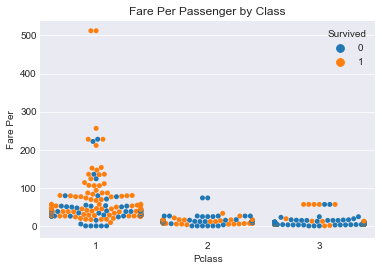

In [28]:
train['Fare Per'] = train['Fare'] / (train['Family'] + 1)
sns.swarmplot(x='Pclass', y='Fare Per', hue='Survived', data=train)
plt.title('Fare Per Passenger by Class')

The graph becomes more vague. It also fails to explain why fare and fare per are similar in class 2 and class 3 despite different qualities. There are even many instances in first class where the fare and fare per are small. I want to look at classes 2 and 3 seperately since they have a similar distribution.

Text(0.5,1,'Passenger Fare by Class')

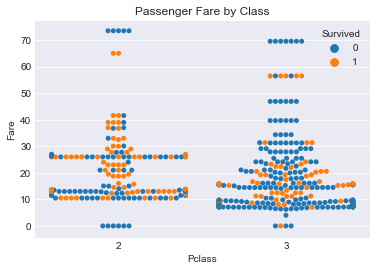

In [29]:
sns.swarmplot(x='Pclass', y='Fare', hue='Survived', data=train[train['Pclass'] != 1])
plt.title('Passenger Fare by Class')

Text(0.5,1,'Fare Per Passenger by Class')

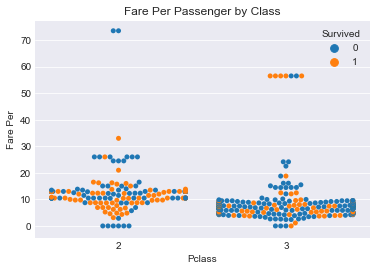

In [30]:
sns.swarmplot(x='Pclass', y='Fare Per', hue='Survived', data=train[train['Pclass'] != 1])
plt.title('Fare Per Passenger by Class')

There are no crazy patterns for survived or deceases. I don't think passenger fare adds anything to predict survivors that we don't already have covered with class. We won't use this for our model.

## Modeling

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

X = train[['Pclass', 'TitleProb', 'Sex Prob', 'Age', 'Family Prob']]
y = train['Survived']

clf = RandomForestClassifier()
param_grid = {'n_estimators':[i for i in range(15, 40)],
              'min_samples_leaf':[i for i in range(1, 15)],        
              'min_samples_split':[2 * i for i in range(10,20)],
              'criterion':['gini', 'entropy']}
randSearch = RandomizedSearchCV(clf, param_distributions=param_grid, cv=10, n_iter=200)
randSearch.fit(X, y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=200, n_jobs=1,
          param_distributions={'n_estimators': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'min_samples_split': [20, 22, 24, 26, 28, 30, 32, 34, 36, 38], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

### Accuracy

In [32]:
'Accuracy: {}'.format(randSearch.best_score_)

'Accuracy: 0.8406285072951739'

In [33]:
'Best Parameters: {}'.format(randSearch.best_params_)

"Best Parameters: {'n_estimators': 25, 'min_samples_split': 30, 'min_samples_leaf': 5, 'criterion': 'entropy'}"

In [34]:
clf = RandomForestClassifier(n_estimators=21, min_samples_split=26, min_samples_leaf=5, criterion='entropy')
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=26,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
feature_importances = clf.feature_importances_
feature_importances = pd.DataFrame(pd.Series(dict(zip(['Pclass', 'TitleProb', 'Sex Prob', 'Age', 'Family Prob'] ,list(feature_importances)))), columns=['Importance'])

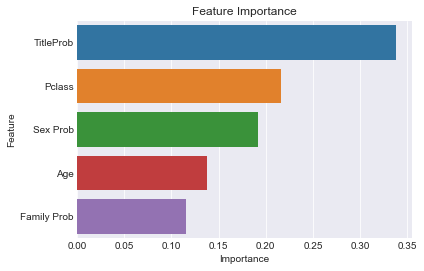

In [36]:
feature_importances['Feature'] = feature_importances.index
feature_importances = feature_importances.sort_values('Importance', ascending=False)
plt.title('Feature Importance')
sns.barplot(x='Importance', y='Feature', data=feature_importances)

# Conclusion

Our cross validated score is 0.841 and our test score is 0.789. This suggests that the model was overfit. I belive that can be partially fixed by changing the input values for family, and more importantly age, using linear regression. Cabin and last names are two other features which could also be utilized to improve score.